# Passo 1: Pré-game

## Importações e configurações

In [58]:
# Bibliotecas que vão ser importadas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,roc_curve,roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso,ElasticNet
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import optuna

# Configurações padrão do matplot lib
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=15,
    titlepad=10,
)

## Pre processamento

Antes de iniciarmos o processo de EDA, faremos um pré processamento dos dados e ele incluirá:
- carregamento
- limpeza
- encoding
- tratamento de missings

Para isso vamos criar funções para modularizar nosso código

In [59]:
## Vamos olhar os valores únicos de cada coluna para entender se existem anomalias para tratarmos na nossa função de limpeza

train = pd.read_csv('train.csv',index_col='PassengerId')
test = pd. read_csv('test.csv',index_col='PassengerId')
full = pd.concat((train,test))

def uniques(X):
    for column in X.columns:
        # Na hora de ordernar quando uma string é comparada com NaN dá erro de comparação de tipos diferentes
        # Por isso vamos dropar os NaN momentaneamente
        print(column)
        unique_val = X[column].dropna()
        unique_val = unique_val.unique()
        unique_val.sort()
        print(unique_val)
        print(30*'#')

uniques(full)


Survived
[0. 1.]
##############################
Pclass
[1 2 3]
##############################
Name
['Abbing, Mr. Anthony' 'Abbott, Master. Eugene Joseph'
 'Abbott, Mr. Rossmore Edward' ... 'van Billiard, Master. Walter John'
 'van Billiard, Mr. Austin Blyler' 'van Melkebeke, Mr. Philemon']
##############################
Sex
['female' 'male']
##############################
Age
[ 0.17  0.33  0.42  0.67  0.75  0.83  0.92  1.    2.    3.    4.    5.
  6.    7.    8.    9.   10.   11.   11.5  12.   13.   14.   14.5  15.
 16.   17.   18.   18.5  19.   20.   20.5  21.   22.   22.5  23.   23.5
 24.   24.5  25.   26.   26.5  27.   28.   28.5  29.   30.   30.5  31.
 32.   32.5  33.   34.   34.5  35.   36.   36.5  37.   38.   38.5  39.
 40.   40.5  41.   42.   43.   44.   45.   45.5  46.   47.   48.   49.
 50.   51.   52.   53.   54.   55.   55.5  56.   57.   58.   59.   60.
 60.5  61.   62.   63.   64.   65.   66.   67.   70.   70.5  71.   74.
 76.   80.  ]
##############################
SibSp
[

Vemos problemas problemas em algumas colunas:
- Age: a idade de algumas pessoas está sendo considerada anos (inteiro) + meses (parte decimal)
- SibSp: existem pessoas com um número muito grande (suspeito) de irmãos/esposas e teremos que investigar se isso é um erro ou não
- Parch: pessoas com um número muito grande de pais/crianças (suspeito) e teremos que investigar se isso é um erro ou não
- Ticket: alguns tickets com padrões estranhos que podem ser erros de imputação
- Cabin: alguns tipos de padrão de letras nas cabines estranhos que precisam ser investigados

### Limpeza

In [60]:
#Vamos primeiro olhar a coluna SibSp e Parch pra entender os números altos de parents

new_cols = full['Name'].str.split(',',n=2,expand=True)
mask = (full['SibSp'].isin([4,5,6,7,8,9])) | (full['Parch'].isin([4,5,6,7,8,9]))

pd.concat([new_cols,full[['SibSp','Parch']]],axis=1).sort_values(by=0).loc[mask]

,0,1,SibSp,Parch
PassengerId,,,,
814,Andersson,Miss. Ebba Iris Alfrida,4,2
69,Andersson,Miss. Erna Alexandra,4,2
542,Andersson,Miss. Ingeborg Constanzia,4,2
851,Andersson,Master. Sigvard Harald Elias,4,2
543,Andersson,Miss. Sigrid Elisabeth,4,2
1106,Andersson,Miss. Ida Augusta Margareta,4,2
14,Andersson,Mr. Anders Johan,1,5
611,Andersson,Mrs. Anders Johan (Alfrida Konstantia Brogren),1,5
120,Andersson,Miss. Ellis Anna Maria,4,2


Realmente essas pessoas tinham um elevado número de irmãos e esposas. Os únicos estranhos são os "Fortune","Lefebre", "Palsson" e "Skoog" e eles analisaremos mais de perto.

In [61]:
new_cols = full['Name'].str.split(',',n=2,expand=True)
mask = (new_cols[0].isin(['Fortune','Lefebre','Palsson','Skoog']))
pd.concat([new_cols,full[['SibSp','Parch']]],axis=1).sort_values(by=0).loc[mask]

,0,1,SibSp,Parch
PassengerId,,,,
28,Fortune,Mr. Charles Alexander,3,2
945,Fortune,Miss. Ethel Flora,3,2
342,Fortune,Miss. Alice Elizabeth,3,2
961,Fortune,Mrs. Mark (Mary McDougald),1,4
439,Fortune,Mr. Mark,1,4
89,Fortune,Miss. Mabel Helen,3,2
410,Lefebre,Miss. Ida,3,1
1024,Lefebre,Mrs. Frank (Frances),0,4
486,Lefebre,Miss. Jeannie,3,1


Olhando mais de perto eles também tem muitos parentes a bordo. Então essa coluna não precisará de nenhum tipo de limpeza. Vamos analisar melhor os tickets agora

In [62]:
tickets_strings = []

for value in full['Ticket'].unique():
    try:
        int(value)
    except:
        tickets_strings.append(value)

df_ticket_strings = pd.DataFrame({'Tickets':tickets_strings})
df_ticket_strings = df_ticket_strings['Tickets'].str.split(' ',n=3,expand=True)

#Na coluna 1 só ficaram os números e queremos ver se achamos algum padrão estranho na coluna 0
df_ticket_strings[0].value_counts().sort_index()


A.             1
A./5.          3
A.5.           3
A/4            4
A/4.           3
A/5           12
A/5.           6
A/S            1
A4.            1
AQ/3.          1
AQ/4           1
C              6
C.A.          27
C.A./SOTON     1
CA             2
CA.            2
F.C.           2
F.C.C.         5
Fa             1
LINE           1
LP             1
P/PP           1
PC            48
PP             2
S.C./A.4.      1
S.C./PARIS     1
S.O./P.P.      5
S.O.C.         1
S.O.P.         1
S.P.           1
S.W./PP        1
SC             2
SC/A.3         1
SC/A4          1
SC/AH          3
SC/PARIS      10
SC/Paris       2
SCO/W          1
SO/C           1
SOTON/O.Q.    14
SOTON/O2       3
SOTON/OQ       8
STON/O        14
STON/O2.       6
STON/OQ.       1
SW/PP          1
W./C.          7
W.E.P.         1
W/C            1
WE/P           1
Name: 0, dtype: int64

É possível perceber vários tipos de erros artograficos, sem contar que o número do ticket não tem muita relevância e vamos descartar ele na etapa de limpeza dos dados. Vamos olhar agora para a coluna de Cabine

In [63]:
#função para retornar somente se for uma string
def is_string(row):
    if type(row) == str:
        return row[0]
    else:
        return row
full['Cabin'].apply(is_string).unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

Aparentemente nenhuma inconsistência também nos dados, porém o número da cabine não será útil para o modelo, então usaremos somente a letra da cabine. A função abaixo será a função de limpeza

In [64]:
def clean(df):

    df = df.copy()
    #temos algumas idades com números fracionados e iremos arrendodar todos para cima
    df['Age'] = np.ceil(df['Age'])
    #corrigindo typos na coluna de ticket e dropando a parte numérica
    df[['Ticket_type','Number_of_ticket_type']] = df['Ticket'].str.split(' ',n=2,expand=True).iloc[:,[0,1]]
    df['Ticket_type'] = df['Ticket_type'].replace({'A.': 'A/1',
                                                'A/4.':'A/4',
                                                 'A4.': 'A/4',
                                                 'AQ/3.': 'AQ/3',
                                                 'A./5.': 'A/5',
                                                 'A.5.': 'A/5',
                                                 'A/5.':'A/5',
                                                 'A/S':'A/5',
                                                 'CA': 'C.A.',
                                                 'CA.':'C.A.',
                                                 'SC/PARIS':'SC/Paris',
                                                 'S.C./PARIS ':'SC/Paris',
                                                 'SOTON/O.Q.':'SOTON/OQ',
                                                 'STON/OQ.': 'SOTON/OQ',
                                                 'SOTON/O2': 'SOTON/O2',
                                                 'STON/O2.' : 'SOTON/O2',
                                                 'S.W./PP': 'SW/PP',
                                                 'W./C.': 'W/C',
                                                 'W.E.P.':'WE/P',
                                                 'S.O.C.': 'SO/C',
                                                 'S.C./A.4.': 'SC/A4',
                                                 'S.C./PARIS':'SC/Paris',
                                                 'SC/A.3': 'SC/A3',
                                                 'F.C.':'FC',
                                                 'F.C.C.':'FC',
                                                 'S.O./P.P.':'S.O/P',
                                                 'S.O.P.':'S.O/P',
                                                 'STON/O': 'SOTON/O'
                                                }) 
    df.drop(columns=['Ticket','Number_of_ticket_type'],inplace=True)

    #Removendo o número da cabine e deixando somente a letra
    df['Cabin'] = df['Cabin'].apply(is_string)
    return df

### Encoding

In [65]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 155.0+ KB


Varias features com o tipo objeto

In [66]:
#Entendendo qual letra de cabine tem mais mortes para quando formos fazer o label encoding conseguirmos ordernar da cabine de menor importância para a de maior importância

survived_cabin = pd.concat((full['Cabin'].apply(is_string),full['Survived']),axis=1)
pd.crosstab(index=survived_cabin['Cabin'],columns=survived_cabin['Survived'],aggfunc='count',values=survived_cabin['Survived']).sort_values(by=1.0,ascending=False)

Survived,0.0,1.0
Cabin,,
B,12.0,35.0
C,24.0,35.0
D,8.0,25.0
E,8.0,24.0
F,5.0,8.0
A,8.0,7.0
G,2.0,2.0
T,1.0,NaN


Dessa forma a ordem do label encoding da feature Cabin será 'T'<'G'<'A'<'F'<'E'<'D'<'C'<'B' considerando que B são os que mais sobrevivem e T os que menos sobrevivem. Vamos olhar agora para os tipos de ticket para entender a ordem das categorias

In [67]:
ticket_converted = []
for value in clean(full)['Ticket_type']:
    
    try:
        ticket_converted.append(int(value))
    except:
        ticket_converted.append(value)

survived_ticket = pd.DataFrame({'ticket':ticket_converted,'Survived':full['Survived']})
survived_ticket['ticket'] =survived_ticket['ticket'].apply(lambda x: 'number_cabin' if type(x) == int else x )

pd.crosstab(index=survived_ticket['ticket'],columns=survived_ticket['Survived'],aggfunc='count',values=survived_ticket['Survived']).sort_values(by=1.0,ascending=False)

Survived,0.0,1.0
ticket,,
number_cabin,407.0,254.0
PC,21.0,39.0
C.A.,27.0,14.0
SC/Paris,6.0,5.0
SOTON/O,7.0,5.0
FC,2.0,4.0
SOTON/O2,5.0,3.0
SW/PP,NaN,2.0
SOTON/OQ,13.0,2.0


Pelos dados parece não haver tanta ordinalidade nessa feature e vamos tratar ela como feature categoria nominal

In [68]:
def encoding(df):
    df = df.copy()

    # Vamos substituir todos os tickets que são números por "number_cabin"
    ticket_converted = []
    for value in df['Ticket_type']:
        try:
            ticket_converted.append(int(value))
        except:
            ticket_converted.append(value)
    df['Ticket_type'] = ticket_converted
    df['Ticket_type'] = df['Ticket_type'].apply(lambda x: 'number_cabin' if type(x) == int else x )


    # separaremos as features categórias em nominais e ordinais
    nominal_cat = ['Name','Sex','Embarked','Ticket_type']

    ordinal_cat = {
                    'Pclass': [3,2,1],
                    'SibSp': [0,1,2,3,4,5,8],
                    'Parch': [0,1,2,3,4,5,6,9],
                    'Cabin': ['T','G','A','F','E','D','C','B']
                  }

    # Adicionando um novo level para valores missing para as categorias ordinais
    #ordered_levels = {key: ["None"] + value for key, value in
    #               ordinal_cat.items()}


    #Categorias nominais
    for name in nominal_cat:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        #if "None" not in df[name].cat.categories:
            #df[name].cat.add_categories("None", inplace=True)
    
    #Categorias ordinais
    for name, levels in ordinal_cat.items():
    #for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

### Missings

Vamos olhar para os valores missings para descobrir a melhor estratégia de preenchimento para cada um

In [69]:
full.isna().sum()

#Volume de missings é expressivo em algumas categorias. O volume de missings em survived são os missings da base de teste, então iremos ignorar eles

Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

<AxesSubplot:xlabel='Fare', ylabel='Cabin'>

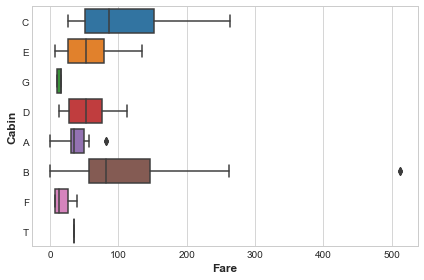

In [70]:
full_clean = clean(full)

sns.boxplot(data=full_clean,y='Cabin',x='Fare',orient='h')

Pelo gráfico é possível perceber que as medianas são diferentes entre sim para cada cabine. Dessa forma, nossa estratégia de missings será escolher a classe que o valor mais se aproxima da mediana

In [71]:
def closest_median_inputation(df_clean):
    # o df é clean porque teoricamente ao usar essa função já teremos feito a limpeza do dataset
    
    df_clean = df_clean.copy()
    #Agrupando cada tipo de cabine e o preço médio
    grouped_cabin = df_clean.groupby('Cabin')['Fare'].median()
    
    #Criando um dicionário em que cada chave é o tipo de cabine e o valor é a média de fare
    median_dict = {cabin: median for cabin,median in zip(grouped_cabin.index,grouped_cabin.values)}
    #median_dict.pop('None')

    def closest_median(row,grouped_cabin=median_dict):
        #Função compara o valor pago pela cabine (para valores missings de tipo de cabine) com a média de cada letra de cabine e escolhe a menor diferença absoluta
        if row == None:
            row = 0
        diferences_dict = {key: value-row for key,value in median_dict.items()}
        return min(diferences_dict, key=diferences_dict.get)
    
    mask = df_clean.loc[:,'Cabin'].isnull()
    new_values = df_clean[mask].loc[:,'Fare'].apply(closest_median)
    df_clean.loc[mask,'Cabin'] = new_values
    
    return df_clean

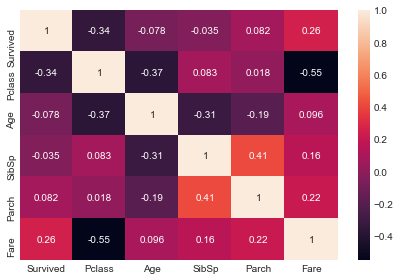

In [72]:
# olhando a coluna Fare, vemos que nenhuma outra coluna do dataset tem alta correlação com ela. 
# Caso houvesse essa elevada correlação, poderíamos fazer uma estratégia de imputação com base em 
# uma reta de regressão entre a feature "Fare" e uma segunda feature
sns.heatmap(clean(train).corr(),annot=True);

Para as colunas de Embarked e Fare usaremos o preenchimento com a moda e mediana respectivamente. Para a coluna Age, usaremos a moda de acordo com o sexo.

In [73]:
def missings(df):
    df = df.copy()

    # Colunas Embarked e Fare
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    #Coluna Cabin
    df = closest_median_inputation(df)

    #Coluna Age
    mask_male = df['Sex'] =='male'
    mask_female = df['Sex'] =='female'
    mode_male = df[mask_male]['Age'].mode()[0]
    mode_female = df[mask_female]['Age'].mode()[0]
    df.loc[((df['Sex'] == 'male') & (df['Age'].isnull())),'Age'] = mode_male
    df.loc[((df['Sex'] == 'female') & (df['Age'].isnull())),'Age'] = mode_female

    return df

Nossa função de pre processamento contemplará o carregamento do dataset, a limpeza, preenchimento de missings e encoding

In [74]:
"""
Revisitando esse projeto percebi que nessa etapa enviesei o preenchimento dos missings na base de teste
já que juntei treino e teste e fiz o preenchimento dos missings com base em métricas do todo. Logo meu modelo
teve missings preenchidos com dados influenciados pela base de teste e na vida real seriam dados que eu não 
teria acesso
"""

def preprocessing():
    train = pd.read_csv('train.csv',index_col='PassengerId')
    test = pd. read_csv('test.csv',index_col='PassengerId')
    full = pd.concat((train,test))
    df = clean(full)
    df = encoding(df)
    df = missings(df)

    df_train = df.loc[train.index,:]
    df_test = df.loc[test.index,:]
    
    return df_train, df_test

df_train, df_test = preprocessing()

In [75]:
display(df_train),display(df_test)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_type
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,F,S,A/5
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C,PC
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,F,S,SOTON/O2
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C,S,number_cabin
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,F,S,number_cabin
...,...,...,...,...,...,...,...,...,...,...,...
887,0.0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,F,S,number_cabin
888,1.0,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,B,S,number_cabin
889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.0,1,2,23.4500,F,S,W/C


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_type
PassengerId,,,,,,,,,,,
892,NaN,3,"Kelly, Mr. James",male,35.0,0,0,7.8292,F,Q,number_cabin
893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,F,S,number_cabin
894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,F,Q,number_cabin
895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,F,S,number_cabin
896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,F,S,number_cabin
...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,"Spector, Mr. Woolf",male,21.0,0,0,8.0500,F,S,A/5
1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9000,C,C,PC
1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,39.0,0,0,7.2500,F,S,SOTON/OQ


(None, None)

In [76]:
df_train.isna().sum(),df_test.isna().sum()

(Survived       0
 Pclass         0
 Name           0
 Sex            0
 Age            0
 SibSp          0
 Parch          0
 Fare           0
 Cabin          0
 Embarked       0
 Ticket_type    0
 dtype: int64,
 Survived       418
 Pclass           0
 Name             0
 Sex              0
 Age              0
 SibSp            0
 Parch            0
 Fare             0
 Cabin            0
 Embarked         0
 Ticket_type      0
 dtype: int64)

Vemos que não temos mais missings

## Função para cálculo do Baseline

In [77]:
def score_dataset(X, y, model=XGBClassifier(use_label_encoder=False,eval_metric='logloss')):
    
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    
    metrics = []

    metrics.append(cross_val_score(model, X, y, cv=5, scoring="precision").mean())
    metrics.append(cross_val_score(model, X, y, cv=5, scoring="recall").mean())
    metrics.append(cross_val_score(model, X, y, cv=5, scoring="accuracy").mean())
 
    return metrics

# Passo 2: EDA para dar insights sobre feature engeneering

In [78]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_type
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,F,S,A/5
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C,PC
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,F,S,SOTON/O2
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C,S,number_cabin
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,F,S,number_cabin


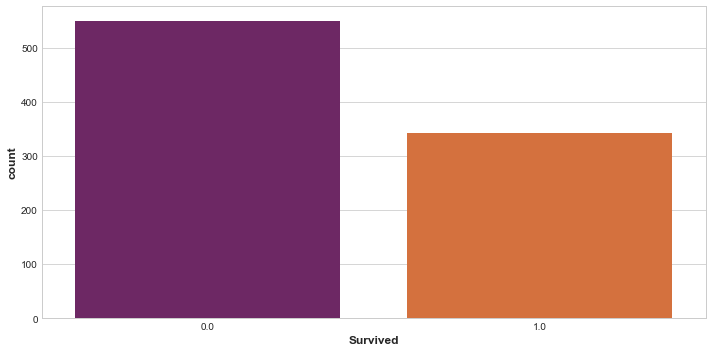

In [79]:
#Olhando como está a distribuição da variável target

fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.countplot(data=df_train, x='Survived',palette='inferno',ax=ax);

Variável target está balanceada

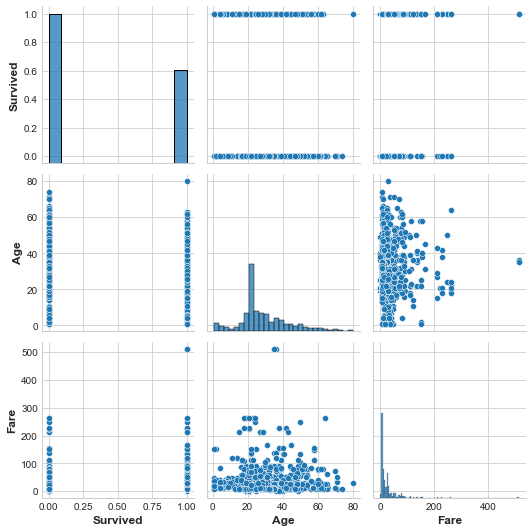

In [80]:
sns.pairplot(df_train);

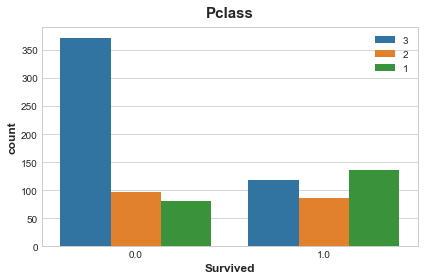

In [81]:
def countplots (hue,data=df_train,x='Survived',**kwargs):
    f = sns.countplot(data=data,x=x,hue=hue)
    f.legend(loc='upper right')
    f.set_title(hue)
    plt.show()

countplots('Pclass')

A maioria das pessoas que morreu estava na 3 classe. Das pessoas que sobreviveram havia uma homogenidade entre as 3 classes

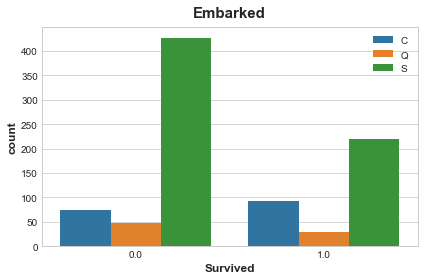

In [82]:
countplots('Embarked')

A maior parte das pessoas embarcou no porto de Southhpton. Quem embarcou pelo porto de Southmpton morreu mais do que sobreviveu proporcionalmente em relação as outros portos

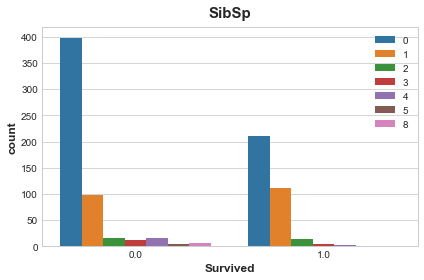

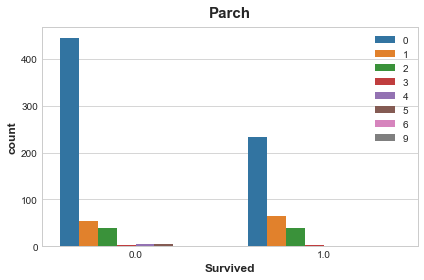

In [83]:
countplots('SibSp')
countplots('Parch')

A maior parte das pessoas que morreram não tinha irmãos ou esposas, talvez seja interessante criar uma variável que mostre isso

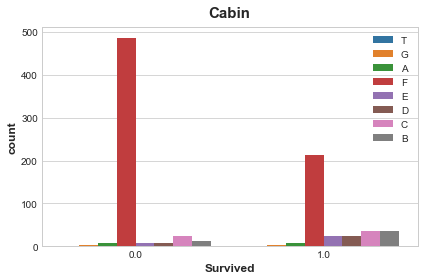

In [84]:
countplots('Cabin')

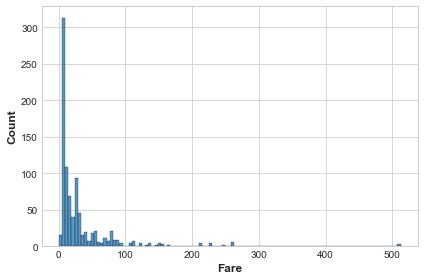

In [85]:
sns.histplot(x=df_train['Fare']);

É possível perceber que o volume de outliers é bem expressivo

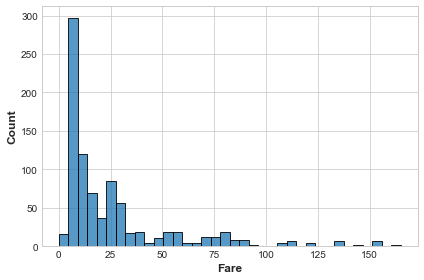

In [86]:
sns.histplot(x=df_train.loc[df_train['Fare']<=200,'Fare']);

O histograma mostra que a maior parte das passagens foram de valores menores, o que explica porque a maior parte das mortes veio da terceira classe 3

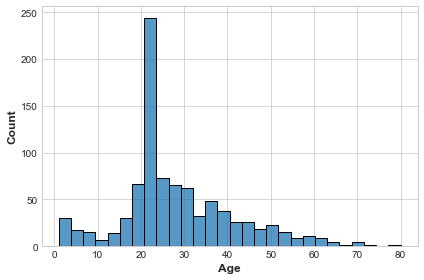

In [87]:
sns.histplot(x=df_train['Age']);

Esse histograma tem esse pico devido a imputação de idades pela moda

In [88]:
pd.pivot_table(
    data=df_train,
    index='Pclass',
    columns='Cabin',
    aggfunc='count',
    values='Name'
)

Cabin,T,G,A,F,E,D,C,B
Pclass,,,,,,,,
3,0,4,0,484,3,0,0,0
2,0,0,0,176,4,4,0,0
1,1,0,15,40,25,29,59,47


As classes E,D,C e B concentram a maior parte dos passageiros de primeira classe e a classe F concentra a maior parte dos passageiros de segunda e terceira classe

In [89]:
pd.pivot_table(
    data=df_train,
    index='Pclass',
    columns='Embarked',
    aggfunc='count',
    values='Name'
)

Embarked,C,Q,S
Pclass,,,
3,66,72,353
2,17,3,164
1,85,2,129


Como a maioria das pessoas que embarcaram pelo porto S eram da terceira classe, está explicado o porque ele foi o porto com mais mortes

In [90]:
pd.pivot_table(
    data=df_train,
    index='Pclass',
    columns='Sex',
    aggfunc='count',
    values='Name'
)

Sex,female,male
Pclass,,
3,144,347
2,76,108
1,94,122


In [91]:
df_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_type
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,F,S,A/5
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C,PC
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,F,S,SOTON/O2
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C,S,number_cabin
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,F,S,number_cabin
...,...,...,...,...,...,...,...,...,...,...,...
887,0.0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,F,S,number_cabin
888,1.0,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,B,S,number_cabin
889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.0,1,2,23.4500,F,S,W/C


# Passo 3: Feature engeneering

## Matual information

Verificando a métrica de mutual information de cada feature com a variável target

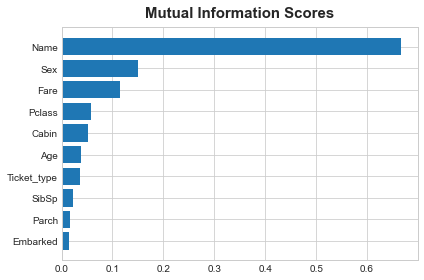

In [92]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


X = df_train.copy()
y = X.pop("Survived")

scores = make_mi_scores(X,y)
plot_mi_scores(scores)

In [93]:
scores

Name           0.665912
Sex            0.150870
Fare           0.115435
Pclass         0.058107
Cabin          0.052092
Age            0.038976
Ticket_type    0.035624
SibSp          0.023197
Parch          0.016366
Embarked       0.014233
Name: MI Scores, dtype: float64

Nenhuma feature é independente da variável target. Como são poucas features por enquanto manteremos mesmo as features que tem baixa relação com o target

## Transformações de colunas

Vamos ransformar a coluna de nomes em uma variável categórica com menos opções

In [94]:
df_train['Name'].str.split(', ',n=1,expand=True)[1].str.split('.',n=1,expand=True)[0].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Lady              1
Sir               1
Mme               1
Don               1
the Countess      1
Ms                1
Jonkheer          1
Capt              1
Name: 0, dtype: int64

Vamos substituir os nomes por categorias de acordo com o título. Seguindo esse dicionário abaixo

    'Mr': 'passenger',
    'Miss': 'passenger',
    'Mrs': 'passenger',
    'Master': 'passenger',          
    'Mlle': 'passenger',     
    'the Countess ' :'passenger',     
    'Mme': 'passenger',          
    'Don' : 'passenger',           
    'Ms': 'passenger',                
    'Jonkheer' : 'passenger',         
    'Lady' : 'passenger',             
    'Sir': 'passenger', 
    'Dr': 'crew',
    'Rev': 'crew',      
    'Col' :'crew',              
    'Major' :'Crew',
    'Capt': 'Crew'       

Vamos criar uma nova coluna de faixa de idades

In [95]:
labels = [f'De {i} até {i+10}' for i in range(0,80,10)]

pd.cut(df_train['Age'],bins=[1,10,20,30,40,50,60,70,80],labels=labels)

PassengerId
1      De 20 até 30
2      De 30 até 40
3      De 20 até 30
4      De 30 até 40
5      De 30 até 40
           ...     
887    De 20 até 30
888    De 10 até 20
889    De 20 até 30
890    De 20 até 30
891    De 30 até 40
Name: Age, Length: 891, dtype: category
Categories (8, object): ['De 0 até 10' < 'De 10 até 20' < 'De 20 até 30' < 'De 30 até 40' < 'De 40 até 50' < 'De 50 até 60' < 'De 60 até 70' < 'De 70 até 80']

Vamos juntar as transformações de colunas com o pandas em uma único função e criar uma outra função para a transformação envolvendo o groupby

In [108]:
def column_transformation (df,df_test=None):
    X = pd.DataFrame()

    #transformando a colune de nomes (se for usar dropar a coluna de nome)
    X['Name_new'] = df['Name'].str.split(', ',n=1,expand=True)[1].str.split('.',n=1,expand=True)[0].replace({
                                                                                                                    'Mr': 'passenger',
                                                                                                                    'Miss': 'passenger',
                                                                                                                    'Mrs': 'passenger',
                                                                                                                    'Master': 'passenger',          
                                                                                                                    'Mlle': 'passenger',     
                                                                                                                    'the Countess ' :'passenger',     
                                                                                                                    'Mme': 'passenger',          
                                                                                                                    'Don' : 'passenger',           
                                                                                                                    'Ms': 'passenger',                
                                                                                                                    'Jonkheer' : 'passenger',         
                                                                                                                    'Lady' : 'passenger',             
                                                                                                                    'Sir': 'passenger', 
                                                                                                                    'Dr': 'crew',
                                                                                                                    'Rev': 'crew',      
                                                                                                                    'Col' :'crew',              
                                                                                                                    'Major' :'crew',
                                                                                                                    'Capt': 'crew'       
        }).astype('category')

    #Criando uma nova coluna de range de idades
    labels = [f'De {i} até {i+10}' for i in range(0,80,10)]
    X['Age_range'] = pd.cut(df['Age'],bins=[1,10,20,30,40,50,60,70,80],labels=labels)

    #Criando uma nova coluna de numero de parentes no navio
    X['Relateds'] = df[['SibSp','Parch']].sum(axis=1)

    #Piorou o modelo
    #A ideia aqui era reduzir o número de categorias nas opções de ticket
    #X['Ticket_type_altered'] =  df['Ticket_type'].apply(lambda x: 'letter_cabin' if x != 'number_cabin' else x).astype('category')

    #Com essa feature melhorou um pouco a acurracia e precisão do modelo
    X['Ticket_type_altered'] =  df['Ticket_type'].replace({
                                                                                                                    'A/5': 'A',
                                                                                                                    'PC':'P',
                                                                                                                    'SOTON/O2': 'SOTON',
                                                                                                                    'number_cabin':'number_cabin',
                                                                                                                    'PP':'P',
                                                                                                                    'C.A.': 'SOTON',
                                                                                                                    'SC/Paris':'SC',
                                                                                                                    'SC/A4':'SC',
                                                                                                                    'A/4':'A',
                                                                                                                    'S.P.':'SC',
                                                                                                                    'SO/C':'SC',
                                                                                                                    'W/C':'W',
                                                                                                                    'SOTON/OQ': 'SOTON',
                                                                                                                    'WE/P':'W',
                                                                                                                    'SOTON/O': 'SOTON',
                                                                                                                    'C':'C',
                                                                                                                    'S.O/P':'SC',
                                                                                                                    'Fa':'F',
                                                                                                                    'LINE':'LINE',
                                                                                                                    'FC':'F',
                                                                                                                    'SW/PP':'SC',
                                                                                                                    'SCO/W':'SC',
                                                                                                                    'P/PP':'P',
                                                                                                                    'SC':'SC',
                                                                                                                    'SC/AH':'SC',
                                                                                                                    'C.A./SOTON':'SOTON'}).astype('category')

    return X

def group_by_transformations (df):
    X = pd.DataFrame()
    X['Fare_by_sex_mean'] = df.groupby('Sex')['Fare'].transform('median')
    X['Embarked_region_mean_fare'] = df.groupby('Embarked')['Fare'].transform('median')
    #Não mudou nada no modelo e não usaremos
    #X['Pclass_region_mean_fare'] = df.groupby('Pclass')['Fare'].transform('median')

    return X

## K-means clustering

In [109]:
features_clustered = [
                        'Relateds',
                        'Fare',
                        'Age',
                        'Fare_by_sex_mean',
                        'Embarked_region_mean_fare',
                        'Pclass_region_mean_fare'
                    ]

def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X[features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new

Label encoding

In [110]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X


Juntando todas as features engenering em uma função temos a seguinte nova função

In [111]:
def feature_eng(df_train,df_test):

    X= df_train.copy()
    X_test = df_test.copy()
    X = pd.concat((X,X_test))
    y = X.pop('Survived')
    X= X.join(column_transformation(X))
    X= X.join(group_by_transformations(X))
    X.drop(columns=['Name','SibSp','Parch'],inplace=True)
    X = label_encode(X)
    #Piorou o modelo, não será usado
    #X = X.join(cluster_labels(df=X,features=features_clustered))

    X_train = X.loc[df_train.index,:]
    X_test = X.loc[df_test.index,:]
    y_train = y.loc[df_train.index]

    return X_train, X_test, y_train

def compare_features(X,y):
    X_base = df_train.copy()
    y_base= X_base.pop('Survived')

    b_metrics = np.round((score_dataset(X_base,y_base)),4)
    feature_metrics = np.round(score_dataset(X,y),4)
    
    table = pd.DataFrame(index=['Baseline','After feature_eng'],columns=['precision','recall','acurracy'],data=[b_metrics,feature_metrics])

    return table


In [112]:
df_train, df_test = preprocessing()
X_train, X_test,y_train = feature_eng(df_train,df_test)
compare_features(X_train,y_train)


,precision,recall,acurracy
Baseline,0.7964,0.7337,0.8238
After feature_eng,0.7843,0.7514,0.8250


É possível perceber que tivemos melhoras no recall e na acurrácia após o feature engeneering. Agora vamos criar uma função para fitar diversos modelos e ver qual é o melhor sem nenhum tipo de ajuste de hipermarâmetros

# Passo 4: Seleção de modelo

In [117]:
def fiter(models,X_train,y_train,ct):
    dicio_models = {} #dicionário em que salvaremos as métricas de cada modelo

    for dicio in models:
        model = dicio.get('estimator')
        pipeline = Pipeline(steps=[
                            ('column_transformer',ct),
                            (f"dicio['model_name']",model)
                        ])
        scores = cross_validate(pipeline,
                        X_train,
                        y_train,
                        scoring=['accuracy','precision','recall','f1','roc_auc'],
                        cv = 5)
        dicio_models[dicio['model_name']] = {
                                               'accuracy':scores['test_accuracy'].mean(),
                                               'precision': scores['test_precision'].mean(),
                                               'recall': scores['test_recall'].mean(),
                                               'f1': scores['test_f1'].mean(),
                                               'auc': scores['test_roc_auc'].mean()
                                            }
    table = pd.DataFrame(dicio_models).T.sort_values(by='auc',ascending=False)

    return dicio_models, table

In [118]:
#Criando o pipeline de modelos
random_seed = 42
models_pipeline = [
                    {
                        "model_name": "Decision Tree",
                        "estimator": DecisionTreeClassifier(random_state=random_seed)
                    },
                    {
                        "model_name": "Random Forest",
                        "estimator": RandomForestClassifier(random_state=random_seed,n_jobs=-1)
                    },
                    {
                        "model_name": "AdaBoost",
                        "estimator": AdaBoostClassifier(random_state=random_seed)
                    },
                    {
                        "model_name": "GradientBoosting",
                        "estimator": GradientBoostingClassifier(random_state=random_seed)
                    },
                    {
                        "model_name": "XGBoost",
                        "estimator": XGBClassifier(random_state=random_seed,use_label_encoder=False,eval_metric = 'logloss',n_jobs=-1)
                    },
                    {
                        "model_name": "LightGBM",
                        "estimator": LGBMClassifier(random_state=random_seed,n_jobs=-1)
                    },
                    {
                        "model_name": "Logistic Regression",
                        "estimator": LogisticRegression(random_state=random_seed,n_jobs=-1)
                    },
                    {
                        "model_name": "CatBoost",
                        "estimator": CatBoostClassifier(random_state=random_seed,verbose=False)
                    },
                  ]

ct = ColumnTransformer([('Scaling',PowerTransformer(),X_train.columns)])

dicio_models,table = fiter(models= models_pipeline,
                    X_train= X_train,
                    y_train= y_train,
                    ct=ct)
table

,accuracy,precision,recall,f1,auc
GradientBoosting,0.830532,0.819860,0.719096,0.764394,0.884284
CatBoost,0.830525,0.825697,0.710401,0.761512,0.876607
Random Forest,0.829421,0.801294,0.736658,0.766671,0.871824
LightGBM,0.835039,0.798463,0.765942,0.779751,0.865217
XGBoost,0.824951,0.784288,0.751364,0.766272,0.858687
AdaBoost,0.810363,0.765918,0.736701,0.748995,0.852855
Logistic Regression,0.795719,0.748464,0.704518,0.725014,0.838094
Decision Tree,0.780033,0.717782,0.707417,0.710947,0.766358


O melhor modelo considerando o critério auc foi o gradiente boost classifier. Dessa forma, faremos a otimização dos hiperparâmetros do mesmo. O modelo Catboost também teve um excelente AUC, iremos otimizar ele também

# Passo 5: Tunning de hiper parâmetros

## Maximizando Accuracy

In [47]:
def objective(trial):
    gradiente_params = dict(
        loss = trial.suggest_categorical("loss", ['deviance', 'exponential']),
        learning_rate=trial.suggest_float("learning_rate", 0.0001,0.1),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        subsample=trial.suggest_float("subsample", 0.1,0.3),
        criterion=trial.suggest_categorical("criterion", ['friedman_mse', 'squared_error']),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        max_depth=trial.suggest_int("max_depth", 3,32),
        max_features=trial.suggest_int("max_features", 7,13 ),
        warm_start=trial.suggest_categorical("warm_start", [True,False]),
        validation_fraction=trial.suggest_float("validation_fraction", 0.1,0.3),
        #n_iter_no_change=trial.suggest_int("n_iter_no_change",5,10),
    )
    gradient = GradientBoostingClassifier(**gradiente_params)
    return cross_validate(gradient,
                        X_train,
                        y_train,
                        scoring=['accuracy'],
                        cv = 3)['test_accuracy'].mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
gradiente_params = study.best_params

[I 2022-02-07 16:47:36,145] A new study created in memory with name: no-name-7f61d87b-28f1-49c5-a902-650c327e3c31
[I 2022-02-07 16:47:47,385] Trial 0 finished with value: 0.8260381593714926 and parameters: {'loss': 'exponential', 'learning_rate': 0.011194993933176177, 'n_estimators': 1755, 'subsample': 0.28307486043306984, 'criterion': 'squared_error', 'min_samples_split': 8, 'max_depth': 30, 'max_features': 12, 'warm_start': True, 'validation_fraction': 0.2849535170909302}. Best is trial 0 with value: 0.8260381593714926.
[I 2022-02-07 16:48:11,307] Trial 1 finished with value: 0.8069584736251403 and parameters: {'loss': 'exponential', 'learning_rate': 0.03816272678025527, 'n_estimators': 5148, 'subsample': 0.13219666288537363, 'criterion': 'squared_error', 'min_samples_split': 3, 'max_depth': 9, 'max_features': 10, 'warm_start': True, 'validation_fraction': 0.13528313012601167}. Best is trial 0 with value: 0.8260381593714926.
[I 2022-02-07 16:48:45,287] Trial 2 finished with value: 0.

E os melhores parâetros são:


In [48]:
gradiente_params

{'loss': 'exponential',
 'learning_rate': 0.0027467342657785014,
 'n_estimators': 2500,
 'subsample': 0.2956125038481136,
 'criterion': 'friedman_mse',
 'min_samples_split': 7,
 'max_depth': 15,
 'max_features': 12,
 'warm_start': False,
 'validation_fraction': 0.2883502119410449}

## Maximizando AUC

In [119]:
def objective(trial):
    gradiente_params = dict(
        loss = trial.suggest_categorical("loss", ['deviance', 'exponential']),
        learning_rate=trial.suggest_float("learning_rate", 0.0001,0.1),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        subsample=trial.suggest_float("subsample", 0.1,0.3),
        criterion=trial.suggest_categorical("criterion", ['friedman_mse', 'squared_error']),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        max_depth=trial.suggest_int("max_depth", 3,32),
        max_features=trial.suggest_int("max_features", 7,13 ),
        warm_start=trial.suggest_categorical("warm_start", [True,False]),
        validation_fraction=trial.suggest_float("validation_fraction", 0.1,0.3),
        #n_iter_no_change=trial.suggest_int("n_iter_no_change",5,10),
    )
    gradient = GradientBoostingClassifier(**gradiente_params)
    return cross_validate(gradient,
                        X_train,
                        y_train,
                        scoring=['roc_auc'],
                        cv = 3)['test_roc_auc'].mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
gradiente_params = study.best_params

[I 2022-02-07 17:38:20,842] A new study created in memory with name: no-name-839ac53e-f781-435a-8b85-6b2cd7c12a99
[I 2022-02-07 17:38:43,860] Trial 0 finished with value: 0.8360016617134822 and parameters: {'loss': 'deviance', 'learning_rate': 0.059043072220543634, 'n_estimators': 4721, 'subsample': 0.2905904614104562, 'criterion': 'squared_error', 'min_samples_split': 5, 'max_depth': 17, 'max_features': 12, 'warm_start': False, 'validation_fraction': 0.283176389501312}. Best is trial 0 with value: 0.8360016617134822.
[I 2022-02-07 17:39:09,460] Trial 1 finished with value: 0.8585146837950979 and parameters: {'loss': 'deviance', 'learning_rate': 0.004218735553557607, 'n_estimators': 2664, 'subsample': 0.25180115806879044, 'criterion': 'friedman_mse', 'min_samples_split': 3, 'max_depth': 9, 'max_features': 9, 'warm_start': False, 'validation_fraction': 0.24994021901048963}. Best is trial 1 with value: 0.8585146837950979.
[I 2022-02-07 17:39:37,027] Trial 2 finished with value: 0.8534975

Agora iremos usar o modelo com os hiperparâmetros para gerar os valores de predição

In [120]:
gradiente_params

{'loss': 'exponential',
 'learning_rate': 0.00911403849724081,
 'n_estimators': 1018,
 'subsample': 0.2886123997411931,
 'criterion': 'friedman_mse',
 'min_samples_split': 2,
 'max_depth': 19,
 'max_features': 7,
 'warm_start': True,
 'validation_fraction': 0.19271702621937112}

In [121]:
ct = ColumnTransformer([('Scaling',PowerTransformer(),X_train.columns)])
my_final_pipe = Pipeline(steps=[('column_transformer',ct),
                            (f"Gradient Boosting Classifier",GradientBoostingClassifier(**gradiente_params))])
my_final_pipe.fit(X_train,y_train)
predictions = my_final_pipe.predict(X_test).astype(int)

pd.DataFrame({'PassengerId': X_test.index, 'Survived': predictions}).to_csv('my_submission.csv', index=False)
print("All done")


All done
